### Part of EECS 6893 - Big Data Analytics - Fall 2021 - Final Project 

* Group ID:- 202112-53
* Title:- Assaying MSD
* Contributors:- Karpagam Murugappan; Arya Kasulla

Year Prediction using K Means clustering

In [2]:
! pip install pyspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 43.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=c940b8360a8a19f042e82923e5472d7420a543358e8294a3f800a5cbf7a05b72
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [3]:
import os
from pyspark import SparkConf                                                                                                                 
from pyspark.context import SparkContext                                                                                                      
from pyspark.sql import SparkSession, SQLContext
from pyspark import *
from pyspark.sql import *
import pandas as pd
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

plt.rcParams['font.size']= 15

In [ ]:
fileObj = open(os.getcwd()+"/data/YearPredictionMSD/YearPredictionMSD.txt", "r")
lines = []
years = set()
ct = 0
for line in fileObj.readlines():
    
    label = int(line[:4])
    years.add(int(label))
    txt=''
    txt+=str(ct)
    txt+=' '
    cc = 0
    #values in positions 1 to 13 - timbre means
    for v in line.split(',')[1:13]:
        cc+=1
        txt+=str(cc)
        txt+=':'
        txt+=v
        txt+=' '
      
      
    lines.append(txt)
    ct+=1
fileObj.close()

with open(os.getcwd()+'/data/kmeans_data_12_features.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')
        
fileObj = open(os.getcwd()+"/data/YearPredictionMSD/YearPredictionMSD.txt", "r")
lines = []
years = set()
ct = 0
for line in fileObj.readlines():
    
    label = int(line[:4])
    years.add(int(label))
    txt=''
    txt+=str(ct)
    txt+=' '
    cc = 0
    for v in line.split(',')[1:]:
        cc+=1
        txt+=str(cc)
        txt+=':'
        txt+=v
        txt+=' '
      
      
    lines.append(txt)
    ct+=1
fileObj.close()

with open(os.getcwd()+'/data/kmeans_data_90_features.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [6]:
print("Number of unique years in the dataset:- ")
print(len(years))

Number of unique years in the dataset:- 
89


In [7]:
'''
Create spark context and session
'''
sc = SparkContext('local')
spark = SparkSession(sc)

### 90 input features

In [8]:
'''
Read the input in LibSVM format
'''
dataset = spark.read.format("libsvm").load(os.getcwd()+'/data/kmeans_data_90_features.txt')

In [9]:
'''
80% Training : 20% Testing split; random seed 100
'''
train, test = dataset.randomSplit([0.8, 0.2], seed = 100)

Silhouette score for 90 clusters:- 0.040772784944324014
# cluster centers:- 90


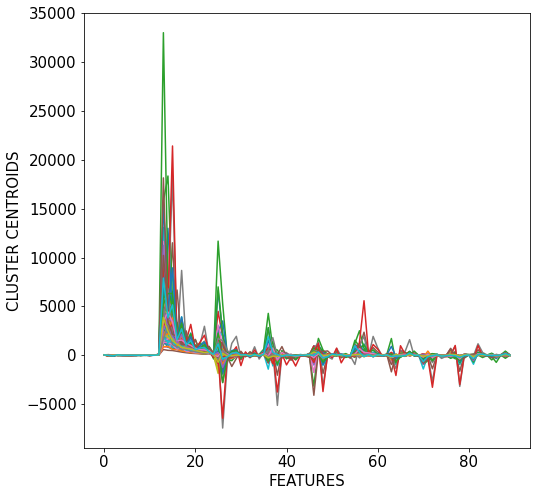

In [10]:
'''
Number of clusters = number of unique years
Random seed 1
10 iterations
'''
kmeans = KMeans().setK(len(years)).setSeed(1).setMaxIter(10)
model = kmeans.fit(train)

# Testing
predictions = model.transform(test)

# Evaluation metric - silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette score for "+str(len(years))+" clusters:- " + str(silhouette))

cluster_centers = model.clusterCenters()
print("# cluster centers:- "+str(len(cluster_centers)))

# Plot the cluster centers
plt.figure(figsize=(8,8))
centers = model.clusterCenters()
ct = 0
for center in centers:
    ct+=1
    plt.plot([o for o in range(len(center))],center,label='C'+str(ct))
plt.xlabel('FEATURES')
plt.ylabel('CLUSTER CENTROIDS')
plt.show()

### 12 input features - only the timbre means

In [37]:
number_of_clusters=[]
silhouette_scores=[]

In [39]:
'''
Read the input in LibSVM format
'''

dataset = spark.read.format("libsvm").load(os.getcwd()+'/data/kmeans_data_12_features.txt')

In [40]:
'''
80% Training : 20% Testing split; random seed 432
'''
train, test = dataset.randomSplit([0.8, 0.2], seed = 432)

Silhouette score for 89 clusters:- 0.11594436276074385
# cluster centers:- 89


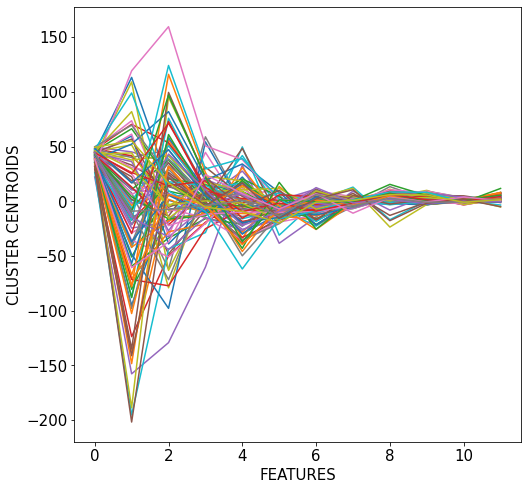

In [41]:
'''
Number of clusters = number of unique years
Random seed 227
10 iterations
'''
number_of_clusters.append(len(years))

kmeans = KMeans().setK(len(years)).setSeed(227).setMaxIter(10)
model = kmeans.fit(train)

# Testing
predictions = model.transform(test)

# Evaluation metric - silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
silhouette_scores.append(silhouette)
print("Silhouette score for "+str(len(years))+" clusters:- " + str(silhouette))

cluster_centers = model.clusterCenters()
print("# cluster centers:- "+str(len(cluster_centers)))

# Plot the cluster centers
plt.figure(figsize=(8,8))
centers = model.clusterCenters()
ct = 0
for center in centers:
    ct+=1
    plt.plot([o for o in range(len(center))],center,label='C'+str(ct))
plt.xlabel('FEATURES')
plt.ylabel('CLUSTER CENTROIDS')
plt.show()

Random cluster number chosen :- 57


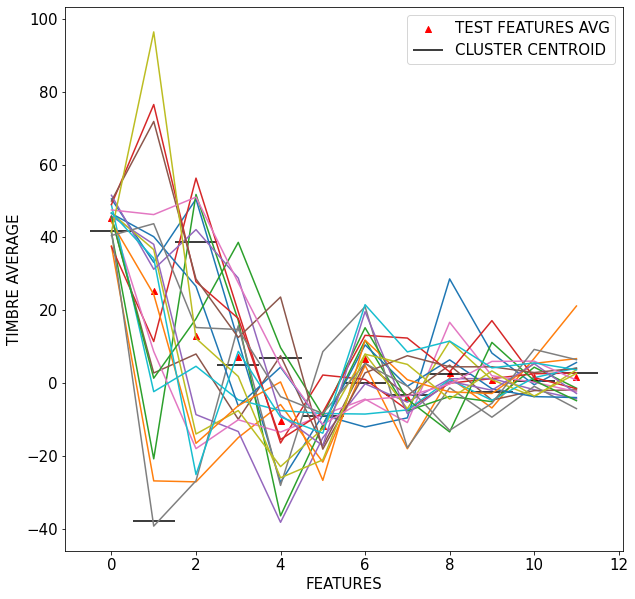

# features with mean close to cluster centroid :- 10


In [42]:
random_cluster_number = np.random.choice([o for o in range(len(years))])
print("Random cluster number chosen :- "+str(random_cluster_number))
#get those rows predicted as random_cluster_number
p1 = predictions.filter(predictions.prediction==str(random_cluster_number)) 
#centroids for random_cluster_number
centroids = model.clusterCenters()[random_cluster_number]
plt.figure(figsize=(10,10))
ll = test.select("features").collect()
ct = 0
sum_features=[0 for o in range(12)]
for row in ll:
  ct+=1
  rr = []
  for k in range(12):
    rr.append(row[0][k])
    sum_features[k]+=row[0][k]
  plt.plot([o for o in range(len(rr))],rr)
  if ct == 20:
    break
average_features=[o/ct for o in sum_features]
plt.scatter([o for o in range(len(average_features))],average_features,marker='^',color='red',label='TEST FEATURES AVG')
for c in range(len(centroids)):
  if c==0:
    plt.hlines(y =centroids[c], xmin = c-0.5, xmax = c+0.5,colors='black',label='CLUSTER CENTROID')
  else:
    plt.hlines(y =centroids[c], xmin = c-0.5, xmax = c+0.5,colors='black')

plt.xlabel("FEATURES")
plt.ylabel("TIMBRE AVERAGE")
plt.legend()
plt.show()

count_close=0
for i in range(len(average_features)):
    if abs(average_features[i]-centroids[c]) <=15:
        count_close+=1

print("# features with mean close to cluster centroid :- "+str(count_close))

Silhouette score for 9 clusters:- 0.2293027689545676
# cluster centers:- 9


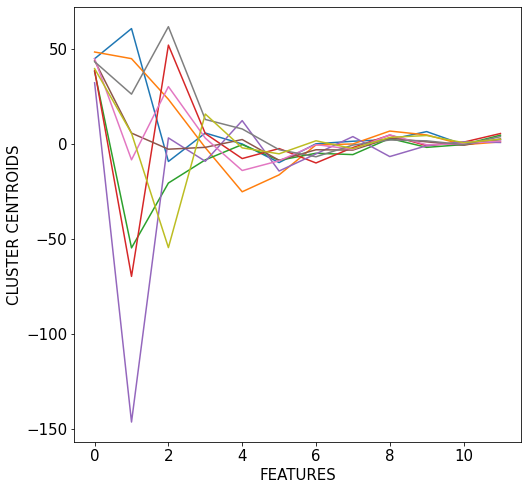

In [43]:
'''
Number of clusters = 9 --> trying to see if forming clusters decade wise can give clear patterns --> 90/10 = 9
Random seed 324
10 iterations
'''
number_of_clusters.append(9)

kmeans = KMeans().setK(9).setSeed(324).setMaxIter(10)
model = kmeans.fit(train)

# Testing
predictions = model.transform(test)

# Evaluation metric - silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
silhouette_scores.append(silhouette)
print("Silhouette score for "+str(9)+" clusters:- " + str(silhouette))

cluster_centers = model.clusterCenters()
print("# cluster centers:- "+str(len(cluster_centers)))

# Plot the cluster centers
plt.figure(figsize=(8,8))
centers = model.clusterCenters()
ct = 0
for center in centers:
    ct+=1
    plt.plot([o for o in range(len(center))],center,label='C'+str(ct))
plt.xlabel('FEATURES')
plt.ylabel('CLUSTER CENTROIDS')
plt.show()

Random cluster number chosen :- 1


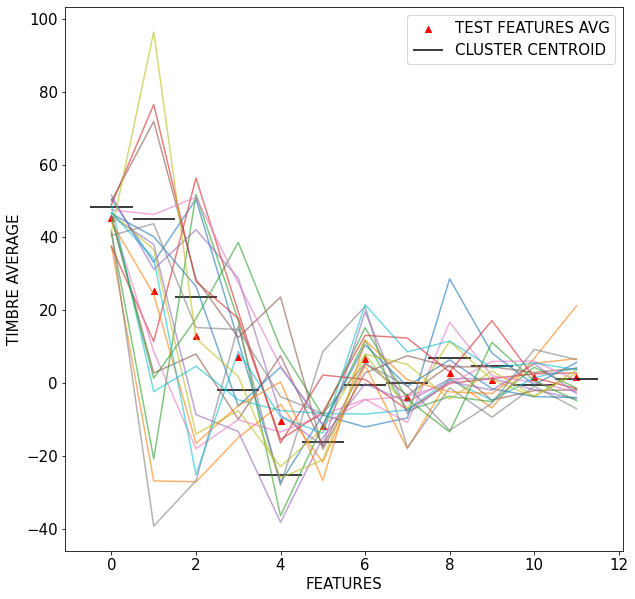

# features with mean close to cluster centroid :- 10


In [44]:
random_cluster_number = np.random.choice([o for o in range(9)])
print("Random cluster number chosen :- "+str(random_cluster_number))
#get those rows predicted as random_cluster_number
p1 = predictions.filter(predictions.prediction==str(random_cluster_number)) 
#centroids for random_cluster_number
centroids = model.clusterCenters()[random_cluster_number]
plt.figure(figsize=(10,10))
ll = test.select("features").collect()
ct = 0
sum_features=[0 for o in range(12)]
for row in ll:
  ct+=1
  rr = []
  for k in range(12):
    rr.append(row[0][k])
    sum_features[k]+=row[0][k]
  plt.plot([o for o in range(len(rr))],rr,alpha=0.6)
  if ct == 20:
    break
average_features=[o/ct for o in sum_features]
plt.scatter([o for o in range(len(average_features))],average_features,marker='^',color='red',label='TEST FEATURES AVG')
for c in range(len(centroids)):
  if c==0:
    plt.hlines(y =centroids[c], xmin = c-0.5, xmax = c+0.5,colors='black',label='CLUSTER CENTROID')
  else:
    plt.hlines(y =centroids[c], xmin = c-0.5, xmax = c+0.5,colors='black')

plt.xlabel("FEATURES")
plt.ylabel("TIMBRE AVERAGE")
plt.legend()
plt.show()

count_close=0
for i in range(len(average_features)):
    if abs(average_features[i]-centroids[c]) <=15:
        count_close+=1

print("# features with mean close to cluster centroid :- "+str(count_close))

Silhouette score for 4 clusters:- 0.3106631497810025
# cluster centers:- 4


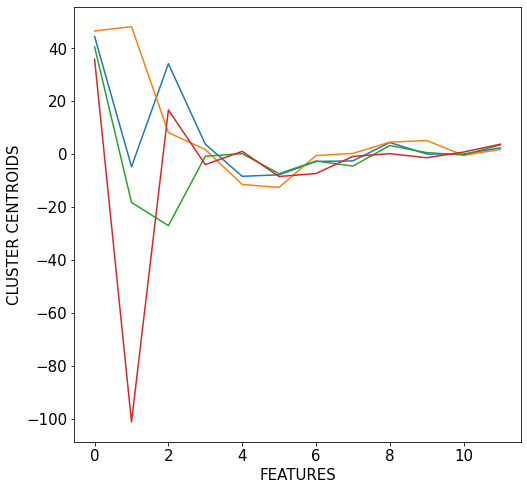

In [45]:
'''
Number of clusters = 4 --> trying to see if forming clusters for every 25 year period can give clear patterns --> 90/25 ~ 4
Random seed 312
10 iterations
'''
number_of_clusters.append(4)

kmeans = KMeans().setK(4).setSeed(312).setMaxIter(10)
model = kmeans.fit(train)

# Testing
predictions = model.transform(test)

# Evaluation metric - silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
silhouette_scores.append(silhouette)
print("Silhouette score for "+str(4)+" clusters:- " + str(silhouette))

cluster_centers = model.clusterCenters()
print("# cluster centers:- "+str(len(cluster_centers)))

# Plot the cluster centers
plt.figure(figsize=(8,8))
centers = model.clusterCenters()
ct = 0
for center in centers:
    ct+=1
    plt.plot([o for o in range(len(center))],center,label='C'+str(ct))
plt.xlabel('FEATURES')
plt.ylabel('CLUSTER CENTROIDS')
plt.show()

Random cluster number chosen :- 3


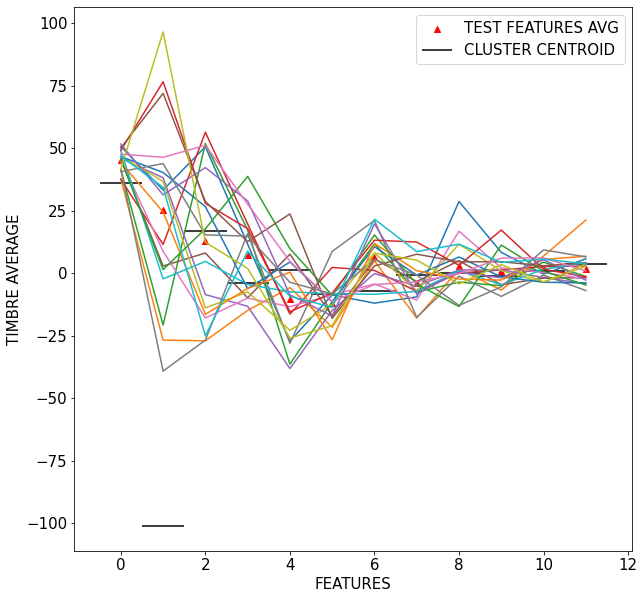

# features with mean close to cluster centroid :- 9


In [47]:
random_cluster_number = np.random.choice([o for o in range(4)])
print("Random cluster number chosen :- "+str(random_cluster_number))
#get those rows predicted as random_cluster_number
p1 = predictions.filter(predictions.prediction==str(random_cluster_number)) 
#centroids for random_cluster_number
centroids = model.clusterCenters()[random_cluster_number]
plt.figure(figsize=(10,10))
ll = test.select("features").collect()
ct = 0
sum_features=[0 for o in range(12)]
for row in ll:
  ct+=1
  rr = []
  for k in range(12):
    rr.append(row[0][k])
    sum_features[k]+=row[0][k]
  plt.plot([o for o in range(len(rr))],rr)
  if ct == 20:
    break
average_features=[o/ct for o in sum_features]
plt.scatter([o for o in range(len(average_features))],average_features,marker='^',color='red',label='TEST FEATURES AVG')
for c in range(len(centroids)):
  if c==0:
    plt.hlines(y =centroids[c], xmin = c-0.5, xmax = c+0.5,colors='black',label='CLUSTER CENTROID')
  else:
    plt.hlines(y =centroids[c], xmin = c-0.5, xmax = c+0.5,colors='black')

plt.xlabel("FEATURES")
plt.ylabel("TIMBRE AVERAGE")
plt.legend()
plt.show()

count_close=0
for i in range(len(average_features)):
    if abs(average_features[i]-centroids[c]) <=15:
        count_close+=1

print("# features with mean close to cluster centroid :- "+str(count_close))

Silhouette score for 2 clusters:- 0.477544353344451
# cluster centers:- 2


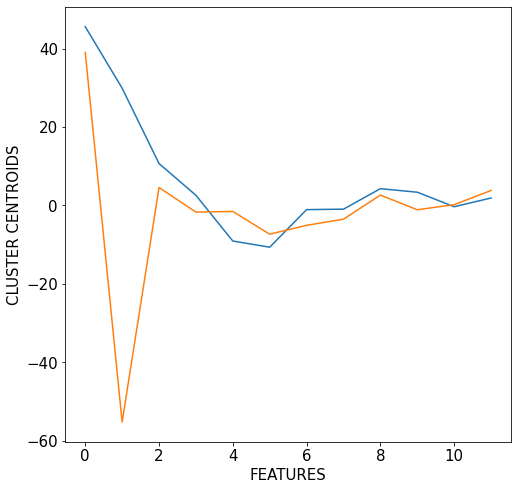

In [48]:
'''
Number of clusters = 2 --> trying to see if forming clusters 90s and 20s can give clear patterns
Random seed 124
10 iterations
'''
number_of_clusters.append(2)

kmeans = KMeans().setK(2).setSeed(124).setMaxIter(10)
model = kmeans.fit(train)

# Testing
predictions = model.transform(test)

# Evaluation metric - silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
silhouette_scores.append(silhouette)
print("Silhouette score for "+str(2)+" clusters:- " + str(silhouette))

cluster_centers = model.clusterCenters()
print("# cluster centers:- "+str(len(cluster_centers)))

# Plot the cluster centers
plt.figure(figsize=(8,8))
centers = model.clusterCenters()
ct = 0
for center in centers:
    ct+=1
    plt.plot([o for o in range(len(center))],center,label='C'+str(ct))
plt.xlabel('FEATURES')
plt.ylabel('CLUSTER CENTROIDS')
plt.show()

Random cluster number chosen :- 0


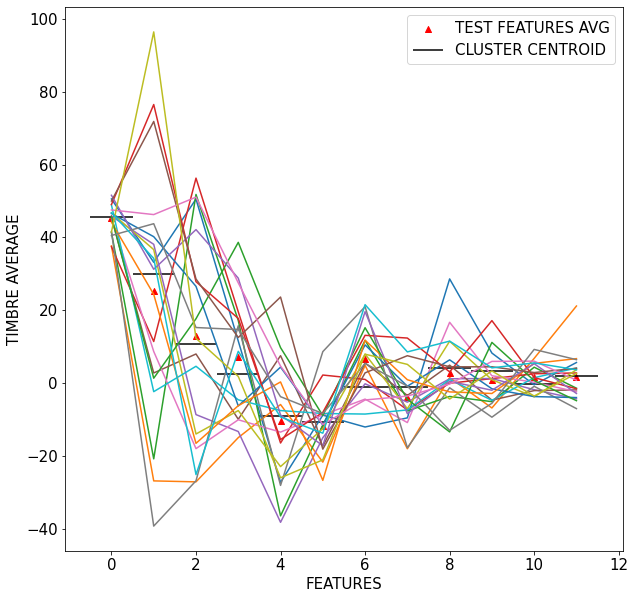

# features with mean close to cluster centroid :- 10


In [50]:
random_cluster_number = np.random.choice([o for o in range(2)])
print("Random cluster number chosen :- "+str(random_cluster_number))
#get those rows predicted as random_cluster_number
p1 = predictions.filter(predictions.prediction==str(random_cluster_number)) 
#centroids for random_cluster_number
centroids = model.clusterCenters()[random_cluster_number]
plt.figure(figsize=(10,10))
ll = test.select("features").collect()
ct = 0
sum_features=[0 for o in range(12)]
for row in ll:
  ct+=1
  rr = []
  for k in range(12):
    rr.append(row[0][k])
    sum_features[k]+=row[0][k]
  plt.plot([o for o in range(len(rr))],rr)
  if ct == 20:
    break
average_features=[o/ct for o in sum_features]
plt.scatter([o for o in range(len(average_features))],average_features,marker='^',color='red',label='TEST FEATURES AVG')
for c in range(len(centroids)):
  if c==0:
    plt.hlines(y =centroids[c], xmin = c-0.5, xmax = c+0.5,colors='black',label='CLUSTER CENTROID')
  else:
    plt.hlines(y =centroids[c], xmin = c-0.5, xmax = c+0.5,colors='black')

plt.xlabel("FEATURES")
plt.ylabel("TIMBRE AVERAGE")
plt.legend()
plt.show()

count_close=0
for i in range(len(average_features)):
    if abs(average_features[i]-centroids[c]) <=15:
        count_close+=1

print("# features with mean close to cluster centroid :- "+str(count_close))

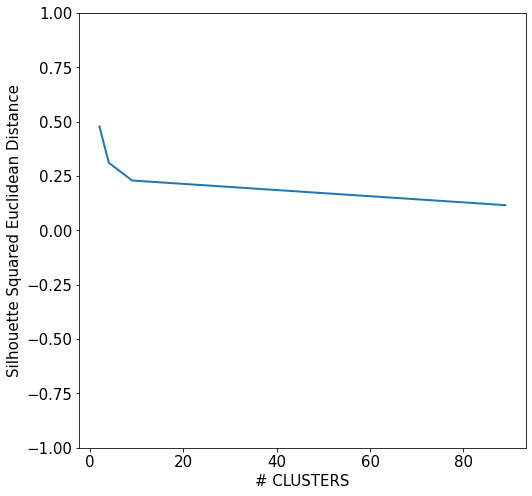

In [51]:
'''
Silhoutte score and number of clusters dependency plot
'''
plt.figure(figsize=(8,8))
plt.plot(number_of_clusters,silhouette_scores,linewidth=2)
plt.xlabel("# CLUSTERS")
plt.ylabel("Silhouette Squared Euclidean Distance")
plt.ylim(-1,1)
plt.show()